## Exploring the Northwind database

In [3]:
import sqlite3

In [4]:
#instantiate connection and cursor
con = sqlite3.connect('Northwind_small.sqlite')
c = con.cursor()

## Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

### Question 1.1: Do discounts have a statistically significant effect on the number of products customers order? 

First, we will list all of the tables in the database to see which ones are relevant to the question.

In [5]:
c.execute('''SELECT name FROM sqlite_master WHERE type='table';''').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

It seems like only four are relevant:
* Products
* Order Details
* Orders
* Customers

Before we dig into the data, we should define our null and alternative hypothesis.

**H<sub>0</sub>:** μ<sub>non</sub> = μ<sub>dis</sub>

**H<sub>1</sub>:** μ<sub>non</sub> ≠ μ<sub>dis</sub>

**$\alpha$:** 0.05

**μ<sub>non</sub>:** mean # of products in non-discounted order

**μ<sub>dis</sub>:** mean # of products in discounted order

**n**: ???


In [6]:
#We will load the 'Order' table to get some example data
import pandas as pd
q1 = pd.DataFrame(c.execute('''SELECT * FROM [Order]''').fetchall())

#Copy column names from SQL database to Pandas DataFrame
q1.columns = [d[0] for d in c.description]

In [7]:
q1.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


The orders table is now in a usable condition, but we will need to join it with 'Order Details' to get the discount information. We will take a look at that table now.

In [8]:
#To make fetching and displaying arbitrary tables from our database easier, 
#we will define a function
def table_fetcher(table_name, limit=0):
    query = f'''SELECT * FROM {table_name}'''
    df = pd.DataFrame(c.execute(query).fetchall())
    df.columns = [d[0] for d in c.description]
    #return entire dataframe if zero is entered as the limit
    if limit == 0:
        return df
    #otherwise, return the number of lines specified
    else:
        return df.head(limit)

In [9]:
#Here we fetch the 'OrderDetail' table to examine it
table_fetcher('OrderDetail', 10)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.00
1,10248/42,10248,42,9.8,10,0.00
2,10248/72,10248,72,34.8,5,0.00
3,10249/14,10249,14,18.6,9,0.00
4,10249/51,10249,51,42.4,40,0.00
5,10250/41,10250,41,7.7,10,0.00
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05


If we take 'number of products customers order' to mean the number of products they buy in a particular order, rather than the entire purchasing history over the time they are a customer, this table may actually have all the info we need. Orders are uniquely identified with 'OrderId', number of products in a given order can be calculated with 'ProductId' and 'Quantity', and total order discount can be calculated by averaging 'Discount' across the entire quantity (or value) of items. 

In [10]:
#copying table into variable for question 1
q1 = table_fetcher('OrderDetail')

In [11]:
#Get the number of unique orders in the DataFrame
print(len(q1['OrderId'].unique()))

830


In [12]:
#Sort the DataFrame by 'OrderId' to make iterating through the data easier
q1.sort_values('OrderId', inplace=True)

In [13]:
#Set last_order_id to something that is very unlikely to ever be an order ID
last_order_id = -1

#Set current index for the new DataFrame so it starts at index 0 when 1 is added
#on the condition of encountering a new row in the old DataFrame
q1_processed_index = -1

#Create new DataFrame with relevant columns
q1_processed = pd.DataFrame(columns=['order_id', 'total_quantity', 'free_products', 'total_value', 'dollars_off'])
#Iterate through rows in old dataframe
for index, data in q1.iterrows():
    #Extract data from each row into variables
    order_id = int(data[1])
    total_quantity = int(data[4])
    price = data[3]
    discount = data[5]
    #Calculate total value of products in row
    total_value = float(total_quantity * price)
    #Calculate number of dollars off for row by multiplying total value by discount
    dollars_off = float(discount * total_value)
    #Calculate number of free products for row by multiplying number of products by discount
    free_products = float(discount * total_quantity)
    #Check if row contains the same order id as the previous one
    if data[1] != last_order_id:
        #If so, add 1 to the new DataFrame index variable
        q1_processed_index += 1
        #Take all the calculated values and place them in the new DataFrame row
        q1_processed.loc[q1_processed_index] = [order_id, total_quantity, free_products, total_value, dollars_off] 
    else: 
        #Otherwise, add the new values to the existing values for that order id
        new_total_quantity = total_quantity + q1_processed.loc[q1_processed_index][1]
        new_free_products = free_products + q1_processed.loc[q1_processed_index][2]
        new_total_value = total_value + q1_processed.loc[q1_processed_index][3]
        new_dollars_off = dollars_off + q1_processed.loc[q1_processed_index][4]
        q1_processed.loc[q1_processed_index] = [order_id, new_total_quantity, new_free_products, new_total_value, new_dollars_off]
    #Update last order id variable so the script knows what order id it processed in the last loop
    last_order_id = order_id
#Display a sample of results
q1_processed.head()

,order_id,total_quantity,free_products,total_value,dollars_off
0,10248.0,27.0,0.00,440.0,0.00
1,10249.0,49.0,0.00,1863.4,0.00
2,10250.0,60.0,7.50,1813.0,260.40
3,10251.0,41.0,1.05,670.8,16.74
4,10252.0,105.0,3.25,3730.0,132.10


In [14]:
#Divide 'dollars_off' by 'total_value' to get the dollar discount rate
q1_processed['dollar_discount'] = q1_processed['dollars_off']/q1_processed['total_value']

In [15]:
#Divide 'free_products' by 'total_quantity' to get the product discount
#(portion of products that were technically free)
q1_processed['product_discount'] = q1_processed['free_products']/q1_processed['total_quantity']

In [16]:
q1_processed.head()

,order_id,total_quantity,free_products,total_value,dollars_off,dollar_discount,product_discount
0,10248.0,27.0,0.00,440.0,0.00,0.000000,0.000000
1,10249.0,49.0,0.00,1863.4,0.00,0.000000,0.000000
2,10250.0,60.0,7.50,1813.0,260.40,0.143629,0.125000
3,10251.0,41.0,1.05,670.8,16.74,0.024955,0.025610
4,10252.0,105.0,3.25,3730.0,132.10,0.035416,0.030952


In [17]:
#Import pyplot and create a scatter plot of the relationship
#between 'dollar_discount' and 'product_discount'
import matplotlib.pyplot as plt
plt.scatter(q1_processed['dollar_discount'], q1_processed['product_discount'])
plt.title('dollar_discount versus product_discount')
plt.xlabel('dollar_discount')
plt.ylabel('product_discount')
plt.show()

<Figure size 640x480 with 1 Axes>

I'm not sure which of these metrics of 'discountedness' is more useful, but to answer this question, we only need to compare the distributions of discounted and non-discounted orders.

In [18]:
#Create separate dataframes with discounted and non-discounted orders
q1_orders_with_discount = q1_processed.loc[q1_processed['dollar_discount']>0, ['total_quantity']]
q1_orders_without_discount = q1_processed.loc[q1_processed['dollar_discount']==0, ['total_quantity']]

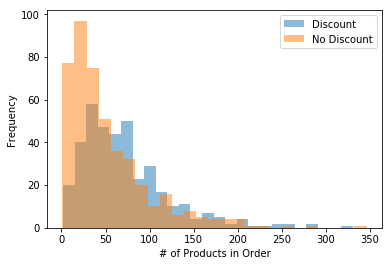

In [19]:
#Plot overlapping histograms of the two populations
plt.hist(q1_orders_with_discount.values, alpha=0.5, label='Discount', bins=25)
plt.hist(q1_orders_without_discount.values, alpha=0.5, label='No Discount', bins=25)
plt.legend()
plt.xlabel('# of Products in Order')
plt.ylabel('Frequency')
plt.show()

It looks like orders with and without discounts have noticeably different distributions. We will go on to examine these distributions statistically to define the relationship between discount and number of products. To be safe, we will use a **two-tailed T-test**.

In [20]:
#Import statistical packages
import numpy as np
import math
from scipy import stats

In [21]:
print(f'non: {len(q1_orders_without_discount)} \ndis: {len(q1_orders_with_discount)}')

non: 450 
dis: 380


In [22]:
#Use the scipy stats T-test function to find our p-value
q1_result = stats.ttest_ind(q1_orders_without_discount, q1_orders_with_discount, equal_var = False)
print(f't-statistic: {q1_result.statistic[0]}\np-value: {q1_result.pvalue[0]}')

t-statistic: -5.886184782446325
p-value: 5.850677815891118e-09


Comparing the resulting p-value of 5.85 * 10<sup>-9</sup> to our $\alpha$ of 0.05, we find that overall, **discounts do have a statistically significant effect on the number of products customers order**. Customers buy more when there is a discount. Now we will examine what levels of discount, if any, do not have a statistically significant effect on products ordered.

### If [discounts have statistically significant effect on # of products ordered], at what level(s) of discount?

Since we know that, overall, discounts do have an effect on # of products sold, we now need to find out what specific levels of discount have an effect.

In [23]:
#Extract all the levels of discount in the discount DataFrame
discount_distribution = q1_processed.loc[q1_processed['dollar_discount']>0, ['dollar_discount']]

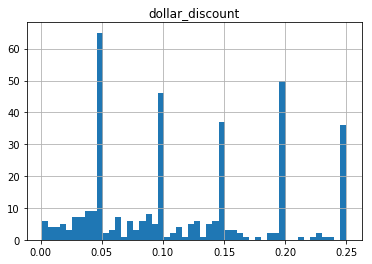

In [24]:
#Plot histogram of discount rates
discount_distribution.hist(bins=50)
plt.show()

It looks like there are spikes in the discount distribution about every 0.05, probably because these were popular levels of discount. I imagine that the values in between are from averaging the discounts of different products in an order.



PROBABLY NEED TO USE ANOVA HERE

In [25]:
#Import important packages for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [26]:
mod = ols('total_quantity ~ dollar_discount', data=q1_processed).fit()

In [27]:
anova_table = sm.stats.anova_lm(mod, typ=2)

In [28]:
print(anova_table)

                       sum_sq     df          F        PR(>F)
dollar_discount  6.542171e+04    1.0  26.174187  3.879254e-07
Residual         2.069565e+06  828.0        NaN           NaN


## Question 2: Do orders contain a statistically significant different value of products when the employee responsible for the sale has the same phone area code as the customer?

Four tables are relevant to this questions:

* Orders
* OrderDetail
* Customer
* Employee

Here we define null and alternative hypotheses:

**H<sub>0</sub>:** μ<sub>same</sub> = μ<sub>diff</sub>

**H<sub>1</sub>:** μ<sub>same</sub> ≠ μ<sub>diff</sub>

**$\alpha$:** 0.05

**μ<sub>same</sub>:** mean value of orders where customer/employee pairs had same phone area code

**μ<sub>diff</sub>:** mean value of orders where customer/employee pairs had different phone area code

**n<sub>same</sub>**: 12

**n<sub>diff</sub>**: 789


In [119]:
file = open('q2_matching-area-codes.db','r')
matching_area_codes = file.read()
file.close()

In [120]:
matching_results = c.execute(matching_area_codes).fetchall()

In [124]:
file = open('q2_nonmatching-area-codes.db', 'r')
nonmatching_area_codes = file.read()
file.close()

In [125]:
nonmatching_results = c.execute(nonmatching_area_codes).fetchall()

In [123]:
#Check results
matching_results

[(2296.0,),
 (956.675,),
 (1388.5,),
 (764.3,),
 (1180.88,),
 (2071.2,),
 (996.0,),
 (468.45,),
 (1416.0,),
 (3523.4,),
 (1924.25,),
 (8902.5,)]

The returned list seems to contain tuples with our number inside. We will write a de-tupling function to extract the value.

In [128]:
def detupler(list):
    return [x[0] for x in list]

In [129]:
matching_results_cleaned = detupler(matching_results)

In [130]:
nonmatching_results_cleaned = detupler(nonmatching_results)

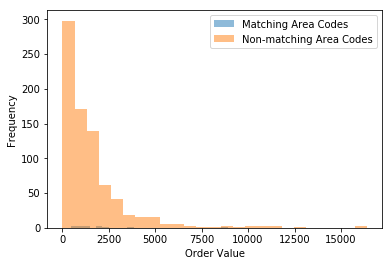

In [131]:
'''
Plot distributions of order value for customer/employee
pairs with matching and nonmatching area codes
'''
plt.hist(matching_results_cleaned, alpha=0.5, label='Matching Area Codes', bins=25)
plt.hist(nonmatching_results_cleaned, alpha=0.5, label='Non-matching Area Codes', bins=25)
plt.legend()
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()

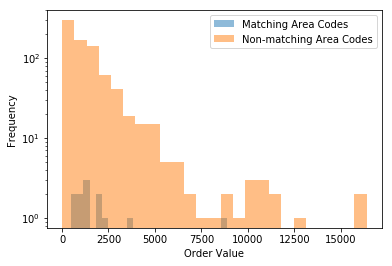

In [132]:
#Re-plot with log scale y axis
plt.hist(matching_results_cleaned, alpha=0.5, label='Matching Area Codes', bins=25)
plt.hist(nonmatching_results_cleaned, alpha=0.5, label='Non-matching Area Codes', bins=25)
plt.legend()
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [133]:
q2_result = stats.mannwhitneyu(
    matching_results_cleaned, nonmatching_results_cleaned, alternative='two-sided'
)

In [134]:
q2_result.pvalue

0.08210731477282339

## Do products in the top quarter by quantity sold have a statistically significant higher reorder threshold than those in the bottom quarter by quantity sold?

## Do customers with streaks of selecting the same shipper 5 or more times in a row have a statistically significant difference in lifetime sales value?

In [82]:
c.execute('''
pragma table_info(Customer)''').fetchall()

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1),
 (1, 'CompanyName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'ContactName', 'VARCHAR(8000)', 0, None, 0),
 (3, 'ContactTitle', 'VARCHAR(8000)', 0, None, 0),
 (4, 'Address', 'VARCHAR(8000)', 0, None, 0),
 (5, 'City', 'VARCHAR(8000)', 0, None, 0),
 (6, 'Region', 'VARCHAR(8000)', 0, None, 0),
 (7, 'PostalCode', 'VARCHAR(8000)', 0, None, 0),
 (8, 'Country', 'VARCHAR(8000)', 0, None, 0),
 (9, 'Phone', 'VARCHAR(8000)', 0, None, 0),
 (10, 'Fax', 'VARCHAR(8000)', 0, None, 0)]